# Weight range target

Example for 5 units into the future. 

Price example for 10 units: 10, 12, 13, 16, 17, 16, 13, 10, 8, 5

At 10 units, next 5 are 12, 13, 16, 17, 16. Want 16 reduced to 10. Solution: Take difference:

At 10 units, next 5 are 2, 3, 6, 7, 6. (5-pos)/5 weight for each value. 

Highest weighted value - lowest weight value is value proposition (vp). 

Plan: 

map(lambda x, p: ((n-p)/n) * x, list[x], range(len(list(x))))

Then map relative strength using log: ln(vp)/ln(close)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ta.trend import SMAIndicator

In [2]:
# Temporary solution
import sys
sys.path.insert(0, '../analysis-features')
import useful_functions as uf

In [3]:
df = pd.read_csv("../data/BTCUSDT-hour.csv")

In [4]:
def get_target(df, span=200):
    """gets the balanced value proposition (highest gain over next 200 - lowest low)"""
    acc = []
    df_len = len(df["close"])

    for i in range(len(df["close"])):

        if i+span < df_len:
            close = df["close"].iloc[i]
            c = df["close"][i:i+span]
            a = list(map(lambda x: x-close, c))
            b = list(map(lambda x, p: ((span-p)/span)*x, a, range(span)))
            
            acc.append(uf.log_abs(max(b) + min(b), zeros=True)/uf.log_abs(close))
        else:
            acc.append(None)

    return acc

def get_sma_rate(df, span=50):
    """returns sma rate list"""
    sma_i = SMAIndicator(close=df["close"], window=span)
    sma = sma_i.sma_indicator()
    past = sma.shift(1)
    return list(map(uf.none_subtraction, sma, past))

def dissuade_from_buying_up(df, span=50, limit=0):
    """prevents buying when span sma's slope is greater than limit"""
    df["sma_rate"] = get_sma_rate(df, span)
    return list(map(lambda sma, t: t if sma<limit else -1,df["sma_rate"], df["target"]))

def classify(df, limit:float):
    """return 1 if value is above limit, else 0"""
    return list(map(lambda x: 0 if x<limit else 1, df["target"]))


In [5]:
df["target"] = get_target(df.copy())
df["target"] = dissuade_from_buying_up(df.copy(), 50, 0)
df["target"] = classify(df.copy(), 0.7)
# df["target"] = dissuade_from_buying_up(df, 20, 0)

In [6]:
df.to_csv("../data/BTCUSDT-hour-target.csv", index=False)

In [2]:
df = pd.read_csv("../data/BTCUSDT-hour-target.csv")

In [3]:
target = df.target

In [13]:
target.value_counts()

0    30704
1     2186
Name: target, dtype: int64

In [14]:
2186/30704

0.07119593538301199

In [13]:
df["scatter_results"] = list(map(lambda x, c: c if x == 1 else None, df["target"], df["close"]))


In [20]:
dp = df[0:10000]
print(df.iloc[2800]["timestamp"])

2017-12-15 02:00:00.000


In [21]:
dp

,timestamp,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,...,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,target,sma_rate,scatter_results
0,2017-08-20 03:00:00.000,4111.26,4111.26,4094.62,4094.62,0.347647,1503201599999,1.428515e+03,3.0,0.347647,...,3.085812,-62.555562,-52.304596,-10.250966,-0.729024,-0.731695,-4.971419,0,NaN,NaN
1,2017-08-20 04:00:00.000,4094.62,4094.62,4091.80,4093.00,0.809243,1503205199999,3.313402e+03,37.0,0.809243,...,2.325000,-64.886401,-54.820957,-10.065444,-0.039564,-0.039572,-5.009016,0,NaN,NaN
2,2017-08-20 05:00:00.000,4087.00,4142.16,4087.00,4117.41,10.743056,1503208799999,4.412284e+04,69.0,9.067067,...,2.235702,-55.814845,-55.019735,-0.795110,0.596384,0.594613,-4.442505,0,NaN,NaN
3,2017-08-20 06:00:00.000,4117.41,4117.41,4081.19,4115.41,2.915551,1503212399999,1.194553e+04,43.0,2.364551,...,0.712627,-56.310248,-55.277837,-1.032410,-0.048574,-0.048586,-4.488922,0,NaN,NaN
4,2017-08-20 07:00:00.000,4081.40,4156.56,4081.40,4155.87,14.136060,1503215999999,5.815740e+04,126.0,7.907226,...,1.956517,-44.320642,-53.086398,8.765757,0.983134,0.978333,-3.549920,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2018-10-13 00:00:00,6298.00,6329.99,6285.07,6317.31,868.209502,1539392399999,5.482756e+06,5578.0,429.285459,...,-0.090147,-11.517804,-7.839372,-3.678431,0.306446,0.305977,46.613118,1,-6.0240,6317.31
9996,2018-10-13 01:00:00,6317.31,6326.47,6311.00,6318.30,975.328318,1539395999999,6.160803e+06,4942.0,541.129701,...,0.080149,-11.274065,-8.526311,-2.747754,0.015671,0.015670,46.636094,1,-6.2540,6318.30
9997,2018-10-13 02:00:00,6318.30,6328.36,6308.56,6310.25,762.568016,1539399599999,4.816459e+06,4776.0,334.864942,...,-0.153640,-12.617034,-9.344456,-3.272579,-0.127408,-0.127489,46.449268,1,-5.0256,6310.25
9998,2018-10-13 03:00:00,6309.07,6316.02,6290.01,6296.01,808.510134,1539403199999,5.099121e+06,4082.0,371.211580,...,-0.720313,-13.253060,-10.126176,-3.126884,-0.225665,-0.225920,46.118784,1,-1.4362,6296.01


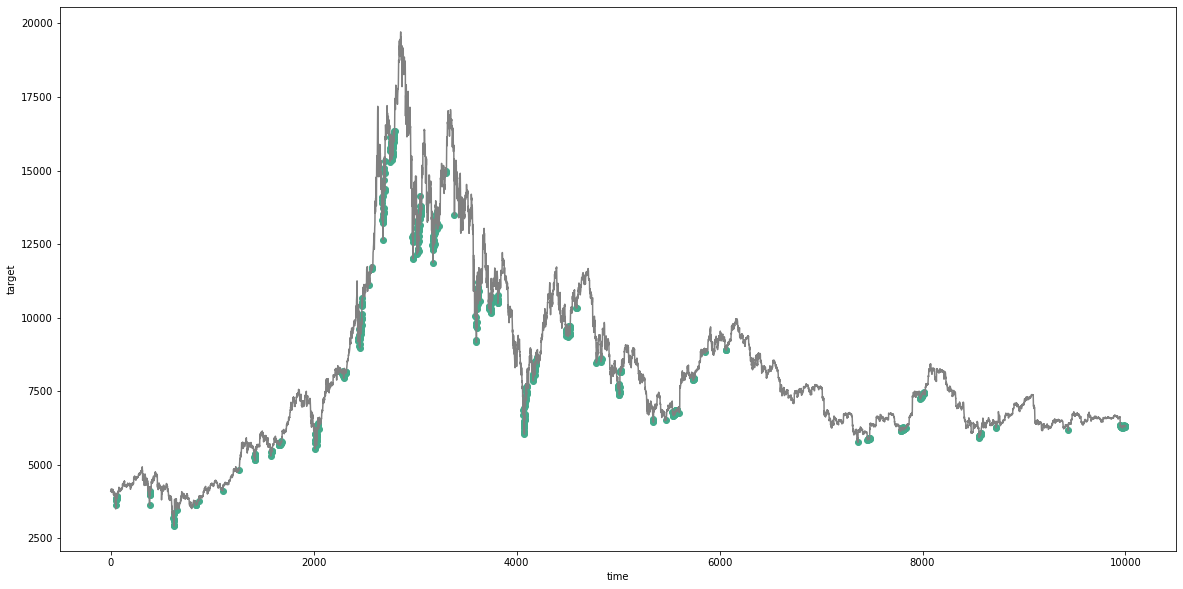

In [22]:
fig,ax = plt.subplots(figsize=(20, 10))
ax.scatter(range(len(dp)),
        dp.scatter_results,
        color="#43aa8b")
# ax.axhline(y=0, color='darkgreen', linestyle='-')
ax.set_xlabel("time")
ax.set_ylabel("target")

# ax.tick_params(labelbottom=False)    
# ax.axes.xaxis.set_visible(False)

# ax2=ax.twinx()
ax.plot(range(len(dp)),
         dp.close,
         color="grey")

# ax.set_ylabel("close")
# fig.legend(["a", "b", "c", "d"])
plt.show()